In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

In [3]:
import cv2
from fastai import *
from fastai.vision import *

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')

In [5]:
fnames = get_image_files(path, recurse=True)
fnames[:5]

[PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_43_1_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H22_31_15_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_9_11_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H14_28_6_hem.bmp'),
 PosixPath('/data/Datasets/WhiteBloodCancer/train/fold_1/hem/UID_H10_189_1_hem.bmp')]

In [6]:
hem_regex = re.compile(r'UID_(H[0-9]+)_')
all_regex = re.compile(r'UID_([0-9]+)_')

In [7]:
hem_files = [fn for fn in fnames if hem_regex.search(str(fn)) is not None]
all_files = [fn for fn in fnames if all_regex.search(str(fn)) is not None]

### Cell shape statistics

In [12]:
def count_cell_pixels(path : Path):
    
    image = cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)
    return len(np.nonzero(image[:, :, 0])[0])    

In [13]:
hem_size = [count_cell_pixels(fn) for fn in tqdm(hem_files)]
all_size = [count_cell_pixels(fn) for fn in tqdm(all_files)]

100%|██████████| 7272/7272 [00:12<00:00, 583.95it/s]


In [21]:
print("Hem {}:".format((np.mean(hem_size, dtype=np.int), np.std(hem_size, dtype=np.int))))
print("ALL {}:".format((np.mean(all_size, dtype=np.int), np.std(all_size, dtype=np.int))))

Hem (26544, 7762):
ALL (36244, 7176):


### Dataset statistics

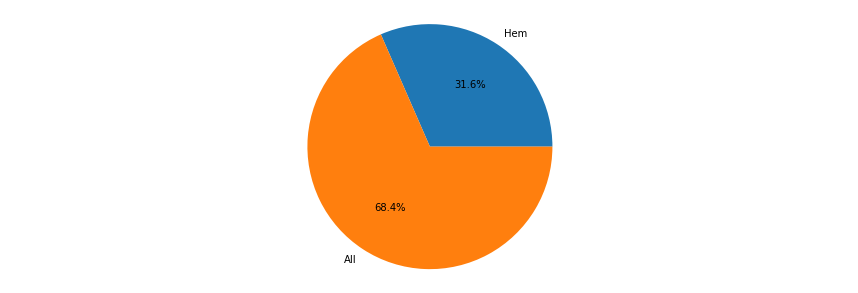

In [22]:
# Data to plot
labels, sizes = ['Hem', 'All'], [len(hem_files), len(all_files)]

plt.figure(figsize=(15,5))
# Plot
plt.pie(sizes, labels=labels, autopct='%1.1f%%')

plt.axis('equal')
plt.show()

#### Patient statistics

In [24]:
hem_patient_ids = list(set([hem_regex.search(str(fn)).group(1)
                            for fn in fnames if hem_regex.search(str(fn)) is not None]))
print('Hem IDs: ' + ' '.join(hem_patient_ids))
print("Count: {}".format(len(hem_patient_ids)))

Hem IDs: H1 H20 H2 H14 H5 H17 H48 H8 H15 H6 H46 H12 H4 H19 H11 H23 H24 H9 H22 H16 H7 H10 H13 H18 H40
Count: 25


In [25]:
all_patint_ids = list(set([all_regex.search(str(fn)).group(1)
                           for fn in fnames if all_regex.search(str(fn)) is not None]))
print('All IDs: ' + ' '.join(all_patint_ids))
print("Count: {}".format(len(all_patint_ids)))

All IDs: 24 72 34 16 33 48 35 27 45 31 18 49 4 30 68 17 47 75 74 67 52 32 44 14 20 15 2 1 21 5 36 43 46 22 19 50 13 3 78 28 26 37 23 25 11 38 51
Count: 47


In [26]:
hem_patients = dict((k,[]) for k in hem_patient_ids)
all_patints = dict((k,[]) for k in all_patint_ids)

[all_patints[key].append(fn) for key in all_patints.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]
[hem_patients[key].append(fn) for key in hem_patients.keys() for fn in fnames if 'UID_{0}_'.format(key) in str(fn)]

print()

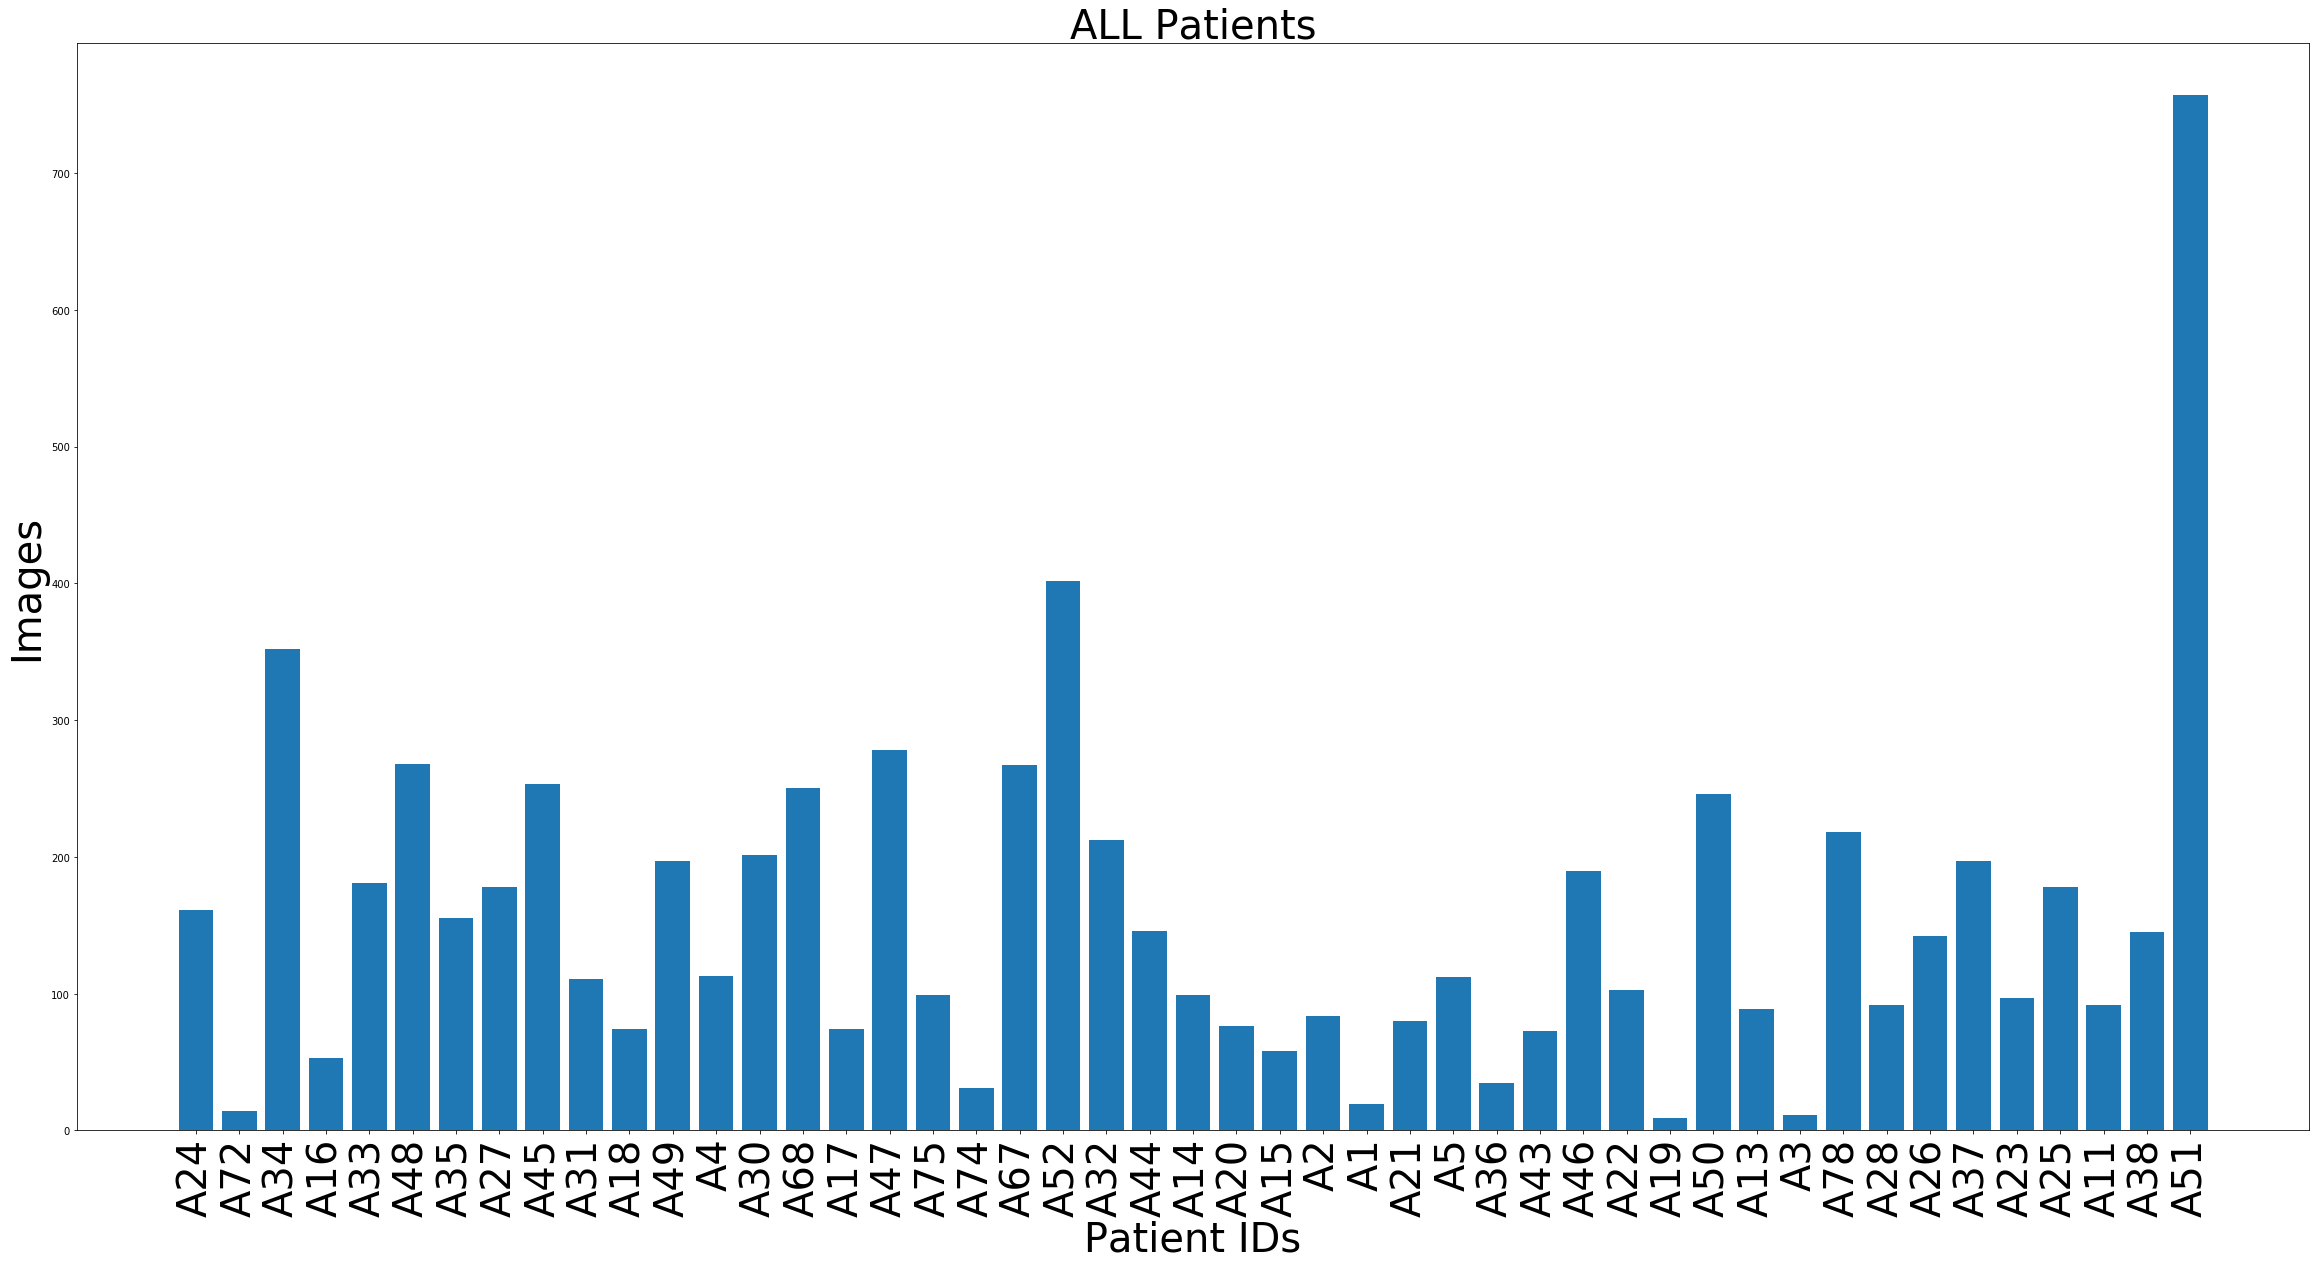

In [29]:
labels, sizes = zip(*[('A{}'.format(key), len(all_patints[key])) for key in all_patints.keys()])
x_pos = [i for i, _ in enumerate(labels)]


plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)
plt.title("ALL Patients", fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

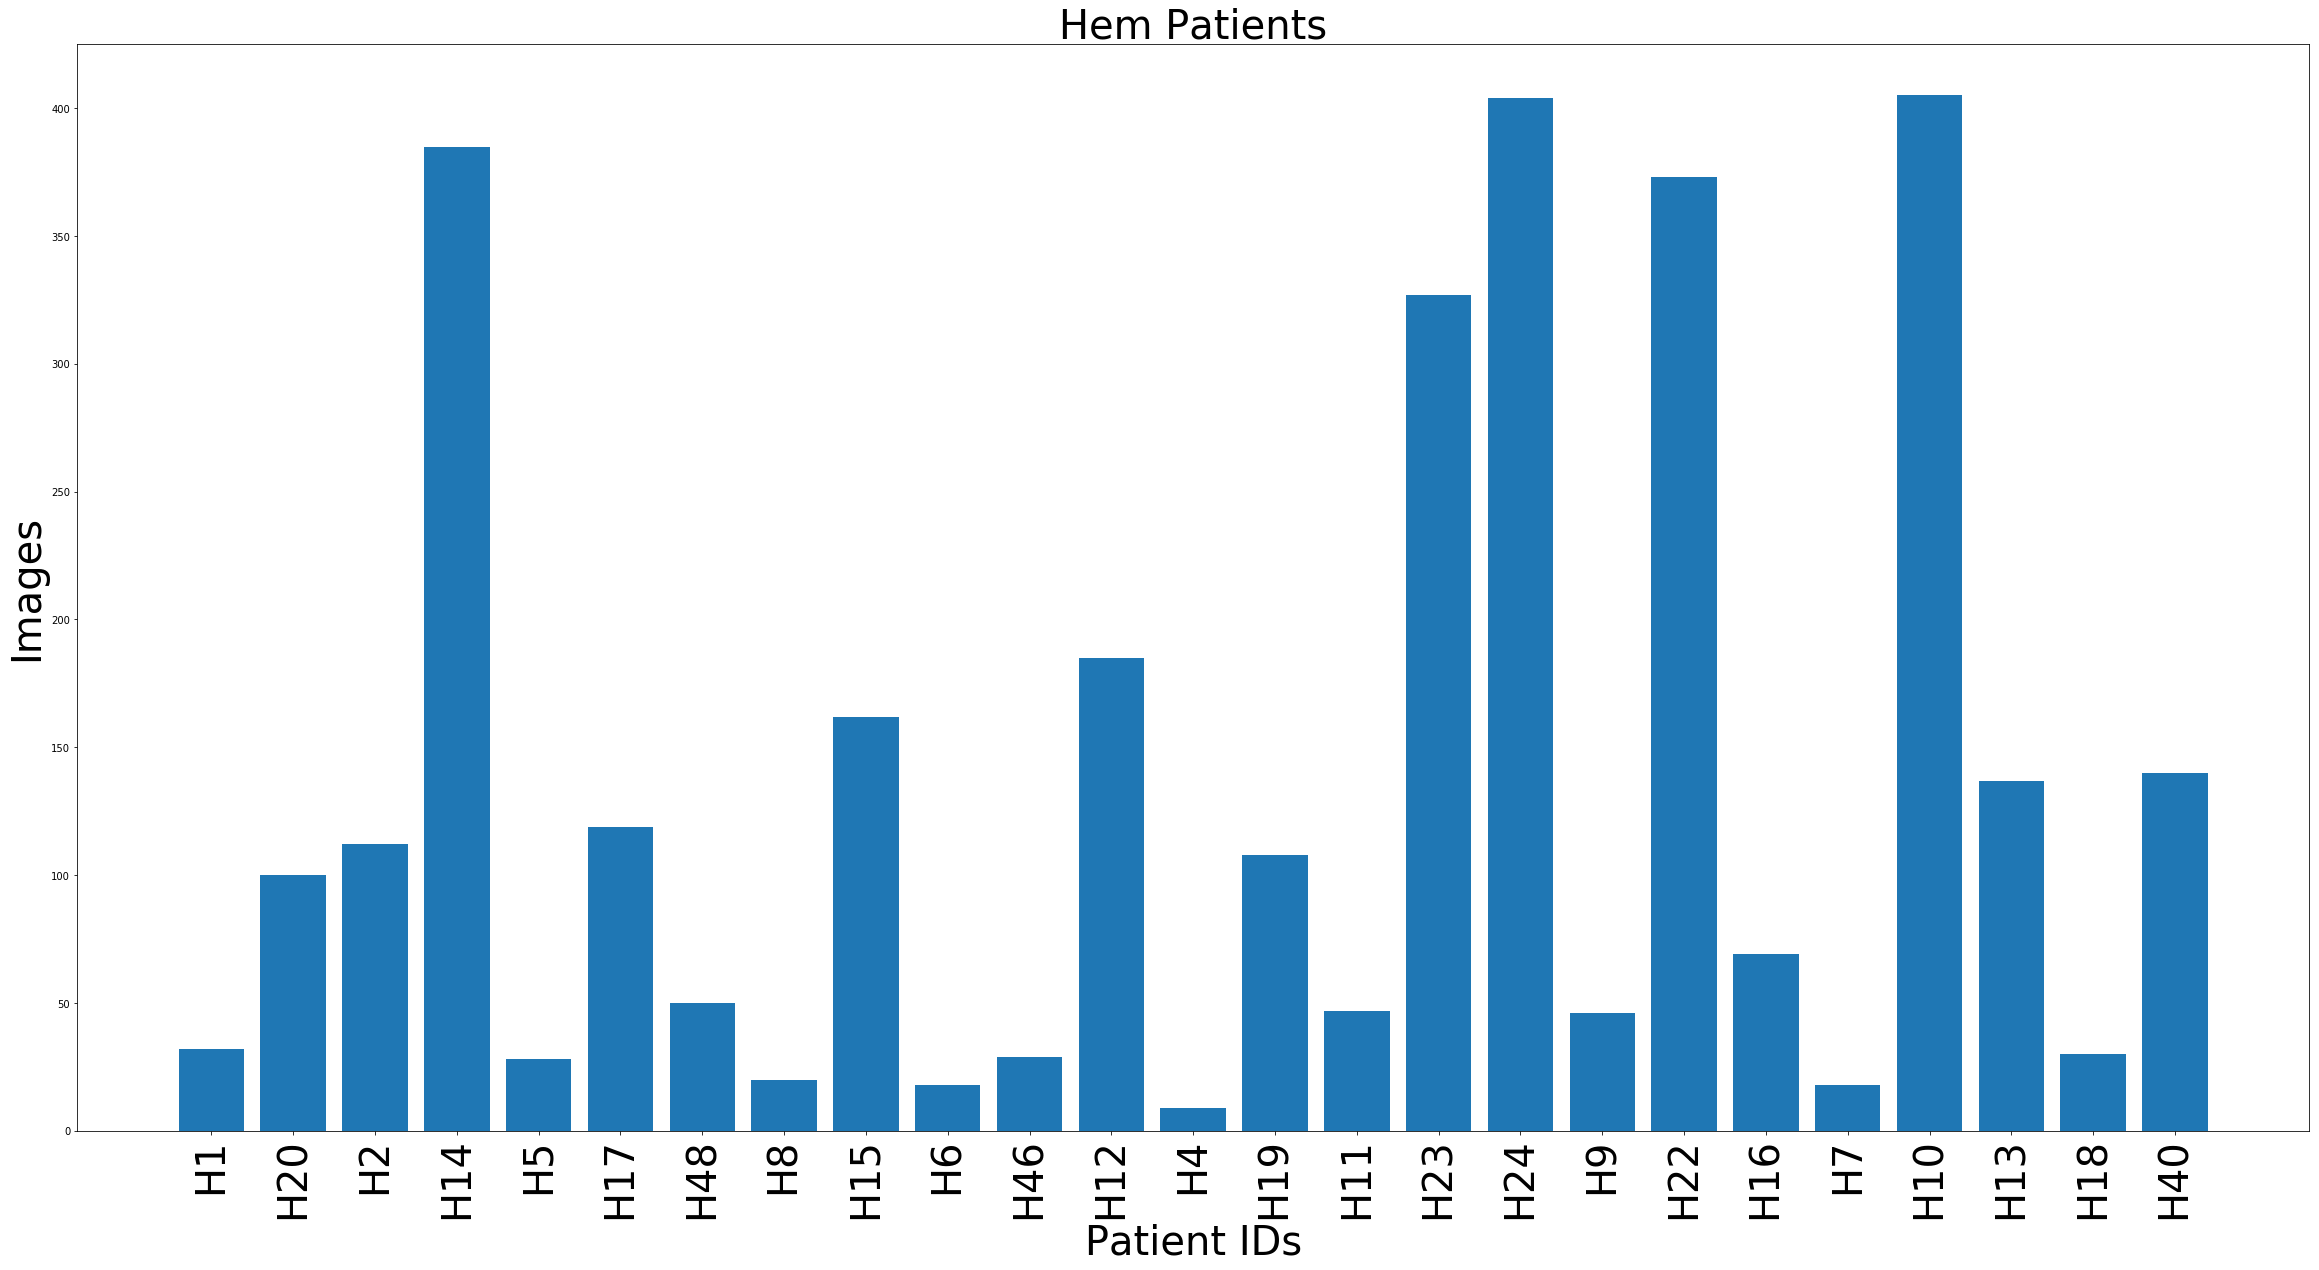

In [30]:
labels, sizes = zip(*[(key, len(hem_patients[key])) for key in hem_patients.keys()])
x_pos = [i for i, _ in enumerate(labels)]


plt.figure(figsize=(40,20))
plt.bar(x_pos, sizes)
plt.xlabel("Patient IDs", fontsize=40)
plt.ylabel("Images", fontsize=40)
plt.title("Hem Patients", fontsize=40)

plt.xticks(x_pos, labels, rotation='vertical', fontsize=40)
plt.show()

## Calc dataset intensity statistics

In [31]:
green_values, red_values, blue_values = None, None, None
for fn in tqdm(hem_files[:150]+all_files[:150]): # use val data!

    image = cv2.cvtColor(cv2.imread(str(fn)), cv2.COLOR_BGR2RGB)

    red_values = image[:, :, 0].flatten() if red_values is None \
        else np.concatenate((red_values, image[:, :, 0].flatten()))

    green_values = image[:, :, 1].flatten() if green_values is None \
        else np.concatenate((green_values, image[:, :, 1].flatten()))

    blue_values = image[:, :, 2].flatten() if blue_values is None \
        else np.concatenate((blue_values, image[:, :, 2].flatten()))

100%|██████████| 300/300 [00:12<00:00, 24.00it/s] 


##### With zero pixel

In [33]:
channel_mean = [np.mean(red_values) / 255., np.mean(green_values) / 255., np.mean(blue_values) / 255.]
channel_std = [np.std(red_values) / 255., np.std(green_values) / 255., np.std(blue_values) / 255.]

print(channel_mean)
print(channel_std)

[0.041866073170338095, 0.018006944049059954, 0.0481688492536109]
[0.10050134081387505, 0.04514805563421087, 0.11444067319013998]


##### Without zero pixel

In [34]:
def mean_non_zero(channel : np):
    return np.mean(channel[np.nonzero(channel)]) / 255.

def std_non_zero(channel : np):
    return np.std(channel[np.nonzero(channel)]) / 255.

channel_mean = [mean_non_zero(red_values), mean_non_zero(green_values), mean_non_zero(blue_values)]
channel_std = [std_non_zero(red_values), std_non_zero(green_values), std_non_zero(blue_values)]

print(channel_mean)
print(channel_std)

[0.2708589820139418, 0.11650518799097075, 0.3116339333043732]
[0.05763743603860378, 0.041383301278654853, 0.051242010796232626]
